In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class MNISTPartialTrainDataset(Dataset):
    def __init__(self, root, num_samples=None, offset=0):
        self.base_dataset = tv.datasets.MNIST(root=root, train=True, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]))
        if num_samples is None:
            self.num_samples = len(self.base_dataset)
        else:
            self.num_samples = min(num_samples, len(self.base_dataset)-offset)
        self.offset = offset
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        return self.base_dataset[self.offset+idx]

class MNISTPartialTestDataset(Dataset):
    def __init__(self, root, num_samples=None, offset=0):
        self.base_dataset = tv.datasets.MNIST(root=root, train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ]))
        if num_samples is None:
            self.num_samples = len(self.base_dataset)
        else:
            self.num_samples = min(num_samples, len(self.base_dataset)-offset)
        self.offset = offset
    def __len__(self):
        return self.num_samples
    def __getitem__(self, idx):
        return self.base_dataset[self.offset+idx]

In [3]:
batch_size = 100
classifier_train_samples  = 30*1000
autoencoder_train_samples = 30*1000

classifier_dataloader = torch.utils.data.DataLoader(
    MNISTPartialTrainDataset(root='../data/mnist', num_samples=classifier_train_samples),
    batch_size=batch_size,
    shuffle=True)

autoencoder_train_dataloader = torch.utils.data.DataLoader(
    MNISTPartialTrainDataset(root='../data/mnist', num_samples=autoencoder_train_samples, offset=classifier_train_samples),
    batch_size=batch_size,
    shuffle=True)

autoencoder_test_dataloader = torch.utils.data.DataLoader(
    MNISTPartialTestDataset(root='../data/mnist'),
    batch_size=batch_size,
    shuffle=True)

In [4]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 20, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(20, 50, 5, 1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(4*4*50, 500),
            nn.ReLU(),
            nn.Linear(500, 10),
            nn.LogSoftmax(),
            )
    def forward(self, x):
        return self.model(x)

In [5]:
classifier = Classifier().to(device)
distance = nn.NLLLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.5)
num_epochs = 20
for epoch in range(num_epochs):
    for data, target in classifier_dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = classifier(data)
        loss = distance(output, target)
        loss.backward()
        optimizer.step()
    print('epoch {:d}/{:d}, loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()), end='\r')

correct = 0
classifier = classifier.to('cpu')
for data, target in classifier_dataloader:
    output = classifier(data)
    pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
print('Classifier train accuracy: {:.1f}%'.format(100*correct/len(classifier_dataloader.dataset)))

C:\Users\mtrencseni\anaconda3\lib\site-packages\torch\nn\modules\container.py:119: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Classifier train accuracy: 99.8%


In [6]:
img_dims = 28

def round_bits(x, quantize_bits):
    mul = 2**quantize_bits
    x = x * mul
    x = torch.floor(x)
    x = x / mul
    return x

class Autoencoder(nn.Module):
    def __init__(self, encoding_dims):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(img_dims*img_dims, encoding_dims),
            nn.ReLU(),
            )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dims, img_dims*img_dims),
            nn.Unflatten(1, (1, img_dims, img_dims)),
            nn.Sigmoid(),
            )
    def forward(self, x, quantize_bits=None):
        x = self.encoder(x)
        x = torch.sigmoid(x)
        if quantize_bits is not None:
            x = round_bits(x, quantize_bits)
        x = torch.logit(x, eps=0.001)
        x = self.decoder(x)
        return x

Doing encoding_dims = 4
encoding_dims = 4, quantize_bits = None, accuracy = 0.36
encoding_dims = 4, quantize_bits = 2, accuracy = 0.19
encoding_dims = 4, quantize_bits = 4, accuracy = 0.30
encoding_dims = 4, quantize_bits = 8, accuracy = 0.37
encoding_dims = 4, quantize_bits = 16, accuracy = 0.36
encoding_dims = 4, quantize_bits = 32, accuracy = 0.36
Doing encoding_dims = 8
encoding_dims = 8, quantize_bits = None, accuracy = 0.20
encoding_dims = 8, quantize_bits = 2, accuracy = 0.17
encoding_dims = 8, quantize_bits = 4, accuracy = 0.18
encoding_dims = 8, quantize_bits = 8, accuracy = 0.19
encoding_dims = 8, quantize_bits = 16, accuracy = 0.20
encoding_dims = 8, quantize_bits = 32, accuracy = 0.20
Doing encoding_dims = 16
encoding_dims = 16, quantize_bits = None, accuracy = 0.69
encoding_dims = 16, quantize_bits = 2, accuracy = 0.31
encoding_dims = 16, quantize_bits = 4, accuracy = 0.44
encoding_dims = 16, quantize_bits = 8, accuracy = 0.65
encoding_dims = 16, quantize_bits = 16, accura

<ipython-input-7-d61294229113>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(20, 2))


encoding_dims = 32, quantize_bits = 4, accuracy = 0.76
encoding_dims = 32, quantize_bits = 8, accuracy = 0.94
encoding_dims = 32, quantize_bits = 16, accuracy = 0.95
encoding_dims = 32, quantize_bits = 32, accuracy = 0.95
Doing encoding_dims = 64
encoding_dims = 64, quantize_bits = None, accuracy = 0.98
encoding_dims = 64, quantize_bits = 2, accuracy = 0.60
encoding_dims = 64, quantize_bits = 4, accuracy = 0.90
encoding_dims = 64, quantize_bits = 8, accuracy = 0.97
encoding_dims = 64, quantize_bits = 16, accuracy = 0.98
encoding_dims = 64, quantize_bits = 32, accuracy = 0.98
Doing encoding_dims = 128
encoding_dims = 128, quantize_bits = None, accuracy = 0.98
encoding_dims = 128, quantize_bits = 2, accuracy = 0.69
encoding_dims = 128, quantize_bits = 4, accuracy = 0.95
encoding_dims = 128, quantize_bits = 8, accuracy = 0.98
encoding_dims = 128, quantize_bits = 16, accuracy = 0.98
encoding_dims = 128, quantize_bits = 32, accuracy = 0.98
Doing encoding_dims = 256
encoding_dims = 256, quan

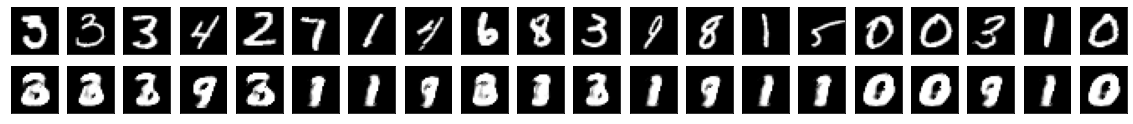

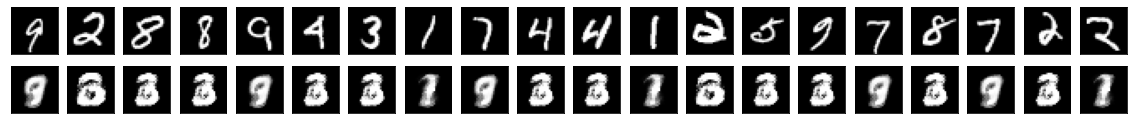

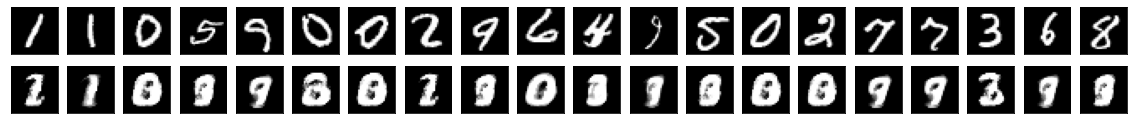

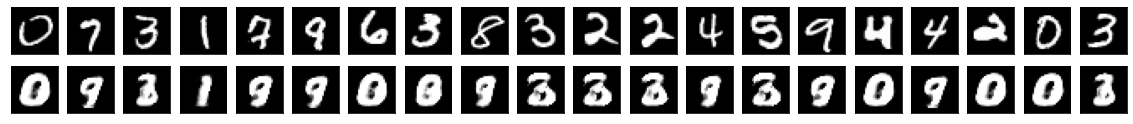

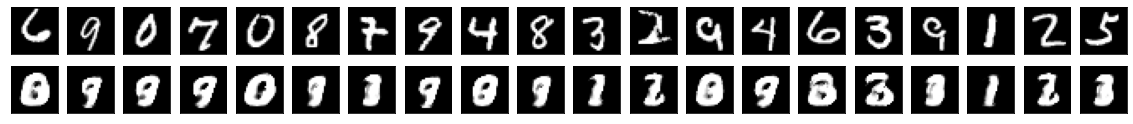

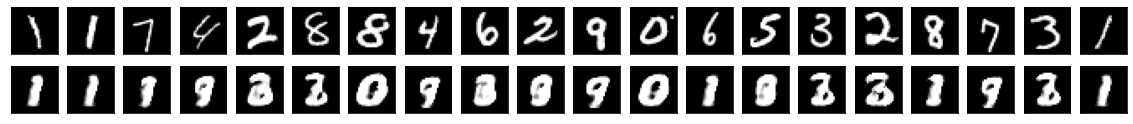

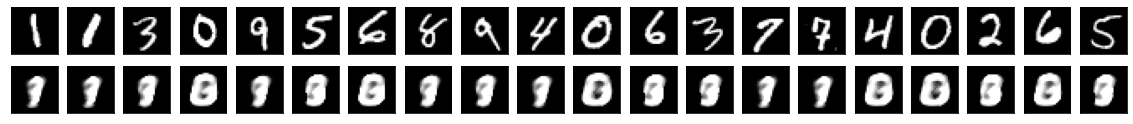

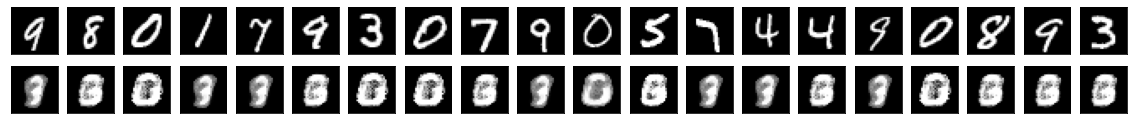

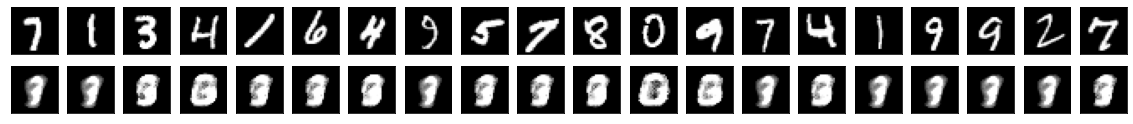

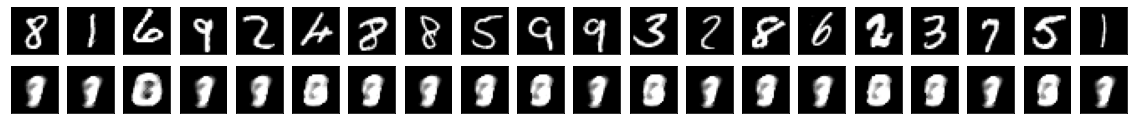

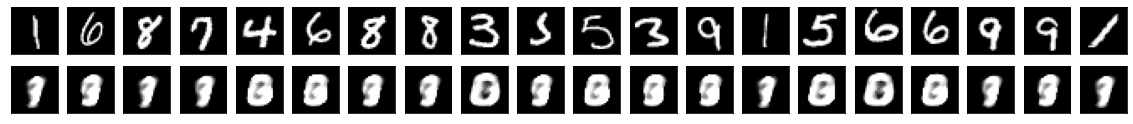

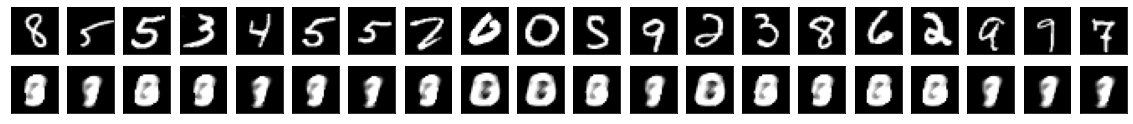

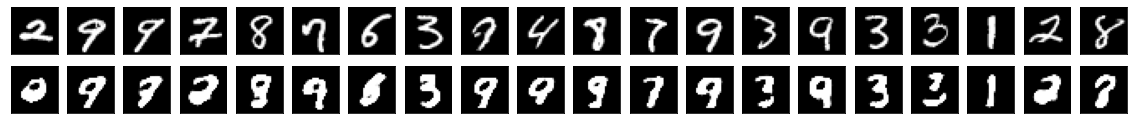

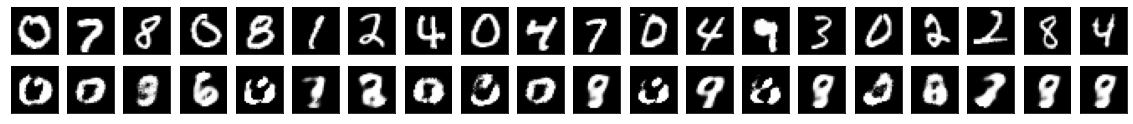

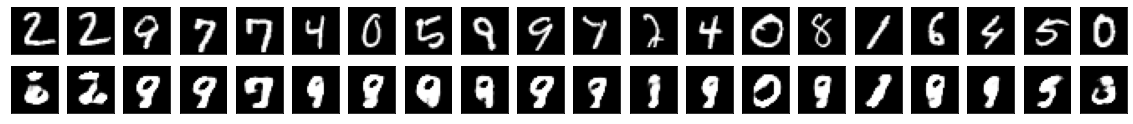

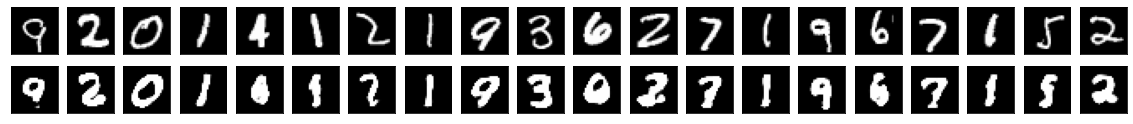

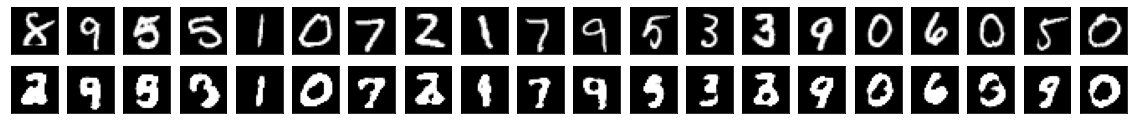

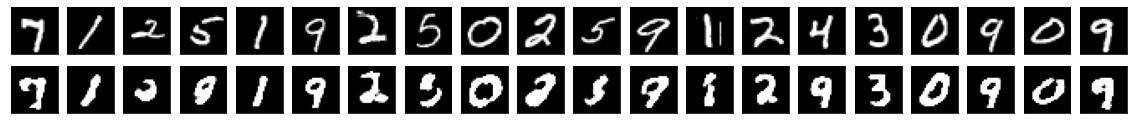

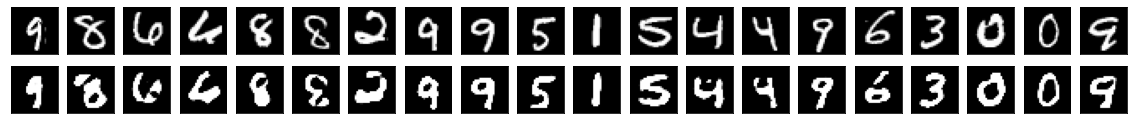

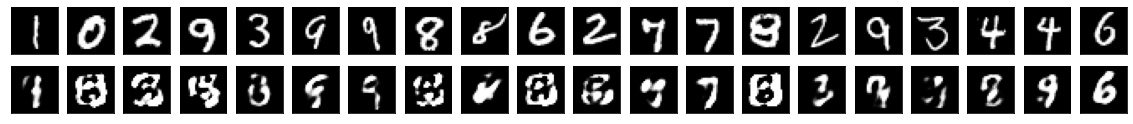

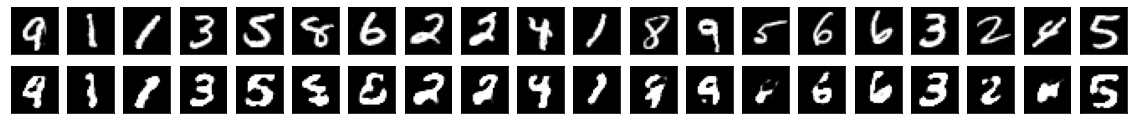

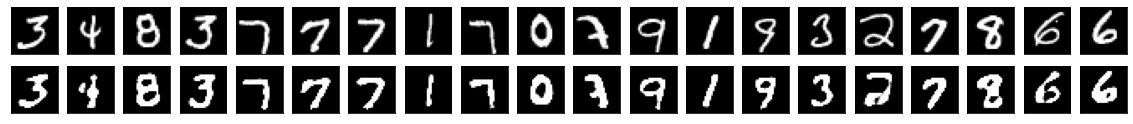

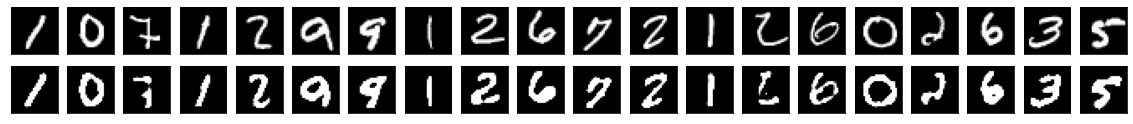

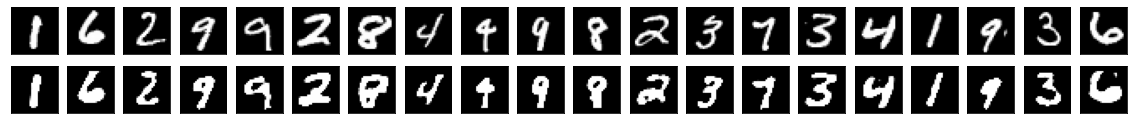

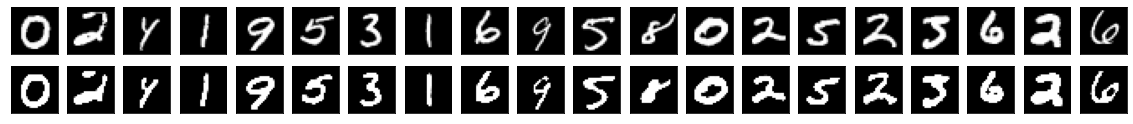

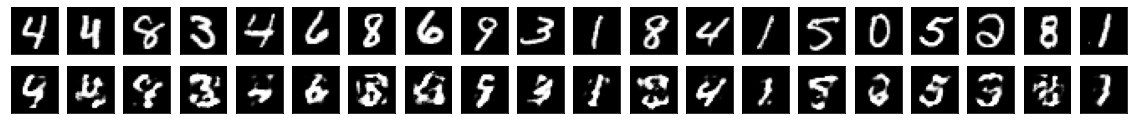

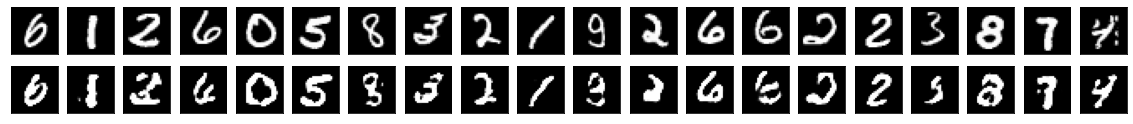

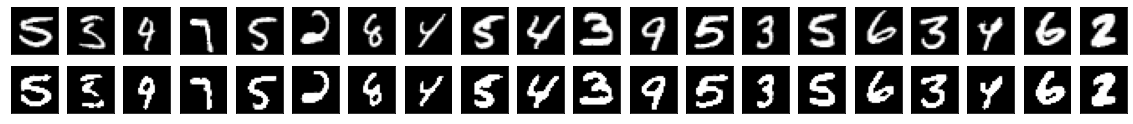

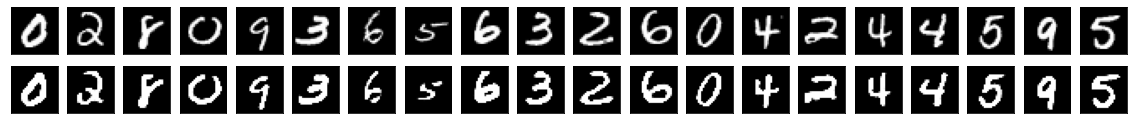

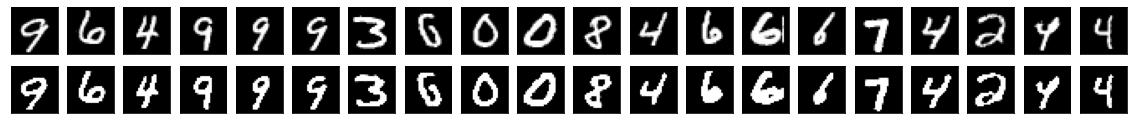

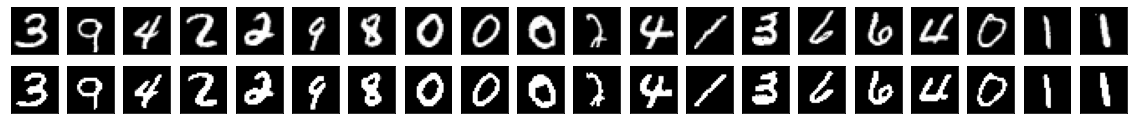

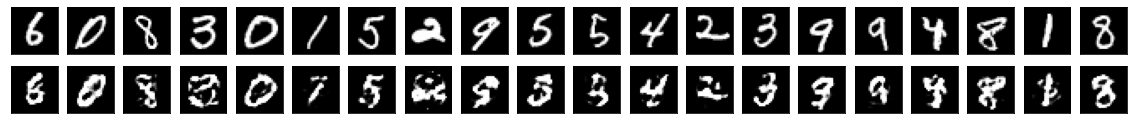

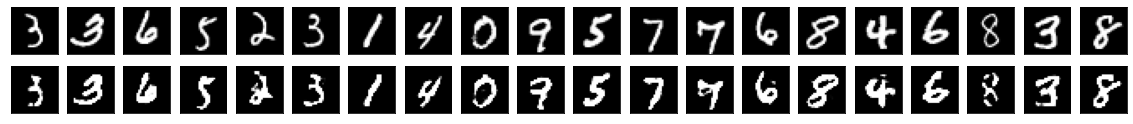

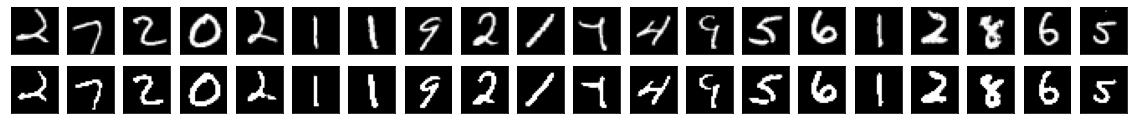

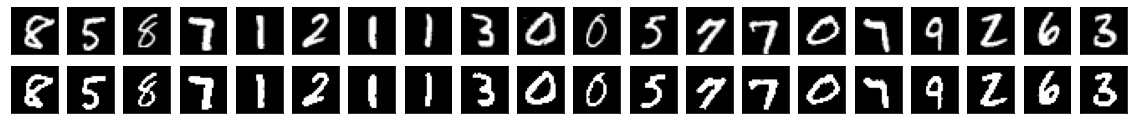

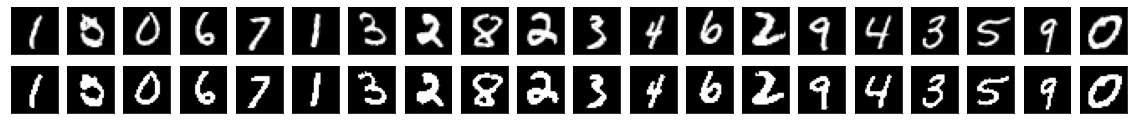

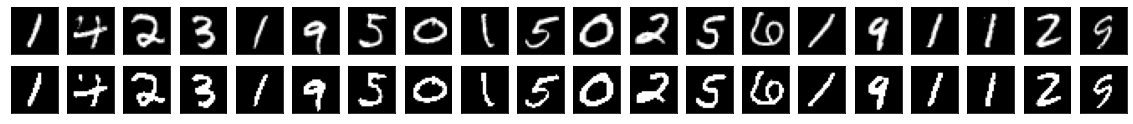

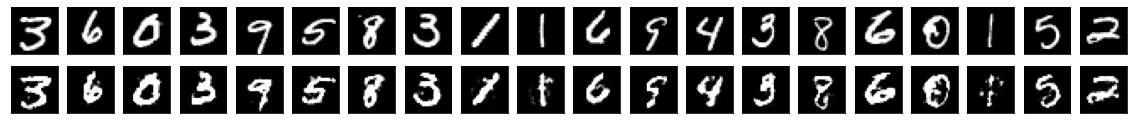

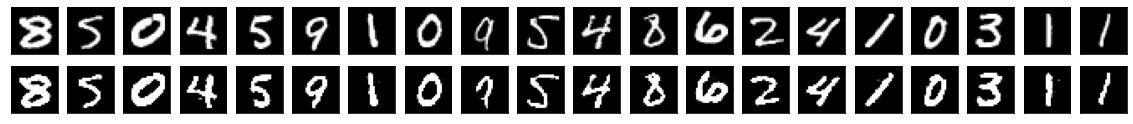

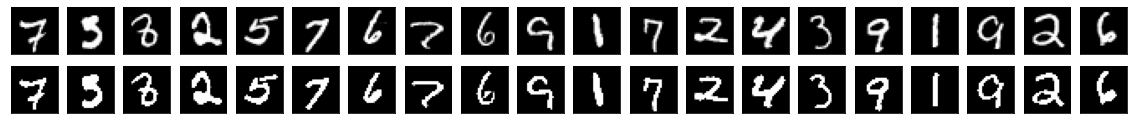

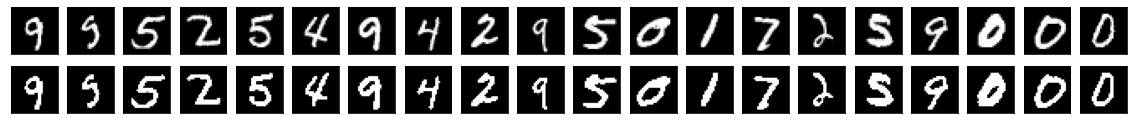

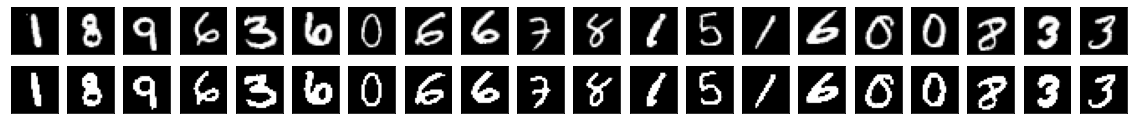

In [7]:
def save_imgs(filename, top, bottom, num_imgs = 20):
    plt.figure(figsize=(20, 2))
    for i in range(num_imgs):
        # display original
        ax = plt.subplot(2, num_imgs, i + 1)
        plt.imshow(top[i].cpu().detach().numpy().reshape(img_dims, img_dims), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        # display reconstruction
        ax = plt.subplot(2, num_imgs, i + 1 + num_imgs)
        plt.imshow(bottom[i].cpu().detach().numpy().reshape(img_dims, img_dims), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.savefig(filename)

results = []
classifier = classifier.to('cpu')
for encoding_dims in [4, 8, 16, 32, 64, 128, 256]:
    # train
    print('Doing encoding_dims = {:d}'.format(encoding_dims))
    autoencoder = Autoencoder(encoding_dims=encoding_dims).to(device)
    distance = nn.BCELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
    num_epochs = 50
    for epoch in range(num_epochs):
        for imgs, _ in autoencoder_train_dataloader:
            imgs = Variable(imgs).to(device)
            output = autoencoder(imgs)
            loss = distance(output, imgs)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            del imgs
            del output
        print('epoch {:d}/{:d}, loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()), end='\r')
    del distance
    del optimizer
    # test
    for quantize_bits in [None, 2, 4, 8, 16, 32]:
        correct = 0
        autoencoder = autoencoder.to('cpu')
        for imgs, labels in autoencoder_test_dataloader:
            ae_imgs = autoencoder(imgs, quantize_bits=quantize_bits)
            output = classifier(ae_imgs)
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(labels.view_as(pred)).sum().item()
        # save some images
        save_imgs('ae_samples_{}_{:d}.png'.format(quantize_bits, encoding_dims), imgs, ae_imgs)
        accuracy = correct/len(autoencoder_test_dataloader.dataset)
        print('encoding_dims = {:d}, quantize_bits = {}, accuracy = {:.2f}'.format(encoding_dims, str(quantize_bits), accuracy))
        results.append((encoding_dims, quantize_bits, accuracy))
    # free CUDA memory
    del autoencoder
    torch.cuda.empty_cache()

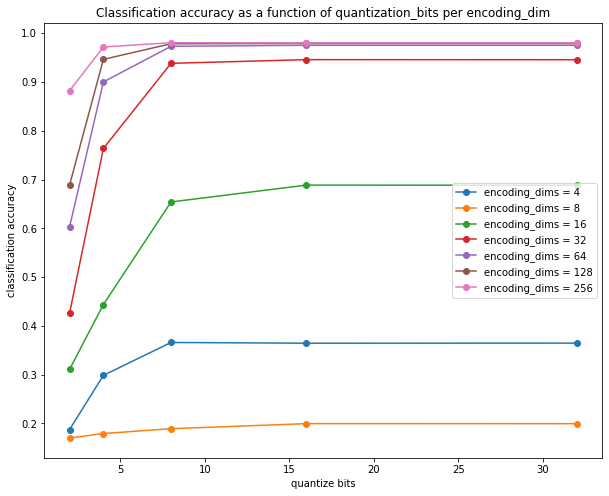

In [8]:
plt.figure(figsize=(10, 8))
quantize_bits = sorted(list(set(map(lambda x: x[1], filter(lambda x: x[1] is not None, results)))))
encoding_dims = sorted(list(set(map(lambda x: x[0], filter(lambda x: x[1] is not None, results)))))
for encoding_dim in encoding_dims:
    y = list(map(lambda x: x[2], filter(lambda x: x[0] == encoding_dim and x[1] is not None, results)))
    plt.plot(quantize_bits, y, label = "encoding_dims = {:d}".format(encoding_dim), marker='o')
plt.xlabel('quantize bits')
plt.ylabel('classification accuracy')
plt.title('Classification accuracy as a function of quantization_bits per encoding_dim')
plt.legend()
plt.show()

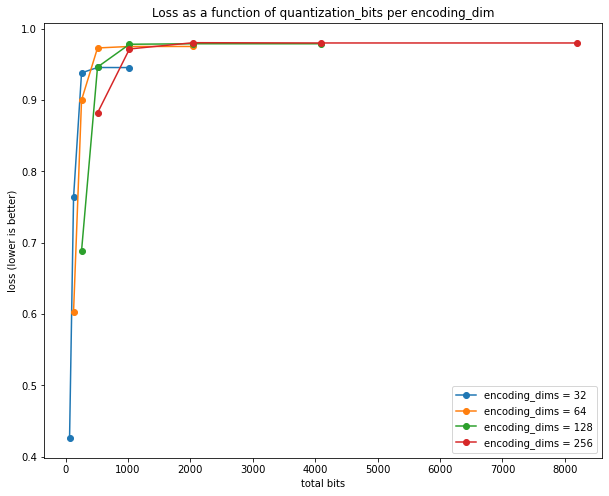

In [9]:
plt.figure(figsize=(10, 8))
quantize_bits = sorted(list(set(map(lambda x: x[1], filter(lambda x: x[1] is not None, results)))))
encoding_dims = [32, 64, 128, 256] # sorted(list(set(map(lambda x: x[0], filter(lambda x: x[1] is not None, results)))))
for encoding_dim in encoding_dims:
    x = list(map(lambda x: x[0]*x[1], filter(lambda x: x[0] == encoding_dim and x[1] is not None, results)))
    y = list(map(lambda x: x[2], filter(lambda x: x[0] == encoding_dim and x[1] is not None, results)))
    plt.plot(x, y, label = "encoding_dims = {:d}".format(encoding_dim), marker='o')
plt.xlabel('total bits')
plt.ylabel('loss (lower is better)')
plt.title('Loss as a function of quantization_bits per encoding_dim')
plt.legend()
plt.show()